In [11]:
# LSTM (long short term memory) helps with vanishing gradiant problem (just a note)
# RNNs are great for sequences

# Recurrent Neural Network (LSTM)

## Part 1 - Data Processing

### Importing the libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Importing the training set

In [8]:
dataset_train = pd.read_csv('data/lstm/Google_Stock_Price_Train.csv')
training_set = dataset_train.iloc[:, 1:2].values # Takes only the column 1 and makes it a np array

In [9]:
dataset_train

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"
...,...,...,...,...,...,...
1253,12/23/2016,790.90,792.74,787.28,789.91,"623,400"
1254,12/27/2016,790.68,797.86,787.66,791.55,"789,100"
1255,12/28/2016,793.70,794.23,783.20,785.05,"1,153,800"
1256,12/29/2016,783.33,785.93,778.92,782.79,"744,300"


In [10]:
training_set

array([[325.25],
       [331.27],
       [329.83],
       ...,
       [793.7 ],
       [783.33],
       [782.75]])

### Feature Scaling

In [14]:
# Standardization (mean and std dev) or Normalization (min/max)

from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled= sc.fit_transform(training_set)


In [15]:
training_set_scaled

array([[0.08581368],
       [0.09701243],
       [0.09433366],
       ...,
       [0.95725128],
       [0.93796041],
       [0.93688146]])

### Create Data Structure with Timesteps

In [18]:
# 60 timesteps and 1 output
# timesteps are important, at each time t it will look at the 60 days previous to make the output suggestion for the next
# The instructor experiemnted until he found 60
# 60 days is basically 3 months of data

X_train = []
y_train = []

# Create sliding window for previous 60 and 61st as label
for i in range(60, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-60:i])  # has 0-59 on first run, 1-60 on second, etc...
    y_train.append(training_set_scaled[i, 0]) # has the label value for 60, then 61, etc...

X_train, y_train = np.array(X_train), np.array(y_train)

### Reshaping

In [19]:
# Only indicator so far is the 60 previous days
# Need more would be helpful, this structure will allow more if we want them (not done here in the tutorial)

# Creating 3d structure
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) # stock prices, timesteps, number of indiccators

# Part 2 - Building the RNN

### Importing the Keras libraries and packages

In [21]:
import tensorflow as tf

2025-01-25 23:05:40.010121: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737867940.061129  252880 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737867940.074625  252880 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-25 23:05:40.206611: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Initializing the RNN

In [31]:
regressor = tf.keras.models.Sequential()

### Adding the first LSTM Layer and some Dropout Regularization

In [32]:
# dropout helps prevent overfitting
# Units = number of cells in this layer (neurons)
# return_sequences = must be true since it is a lstm layer, default is faule for last layer
# input shape = shape of X_train (3d)

regressor.add(tf.keras.layers.LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
regressor.add(tf.keras.layers.Dropout(rate=0.2)) # rate of neurons to ignore in the layer, this is 20% of layer ignored (10 in this case)

/home/fraher/code/deepnn/.env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Adding a second LSTM layer and some Dropout regularization

In [33]:
regressor.add(tf.keras.layers.LSTM(units=50, return_sequences=True))
regressor.add(tf.keras.layers.Dropout(rate=0.2))

### Adding a third LSTM layer and some Dropout regularization

In [34]:
regressor.add(tf.keras.layers.LSTM(units=50, return_sequences=True))
regressor.add(tf.keras.layers.Dropout(rate=0.2))

### Adding a fourth LSTM layer and some Dropout regularization

In [35]:
regressor.add(tf.keras.layers.LSTM(units=50)) # don't need return_sequences since last LSTM layer, defaults to False
regressor.add(tf.keras.layers.Dropout(rate=0.2))

### Adding the output layer

In [36]:
regressor.add(tf.keras.layers.Dense(units=1)) # Stock price at t+1

### Compiling the RNN

In [37]:
regressor.compile(optimizer='adam', loss='mean_squared_error') # adam is always safe, but RMSProp is recommended for RNN didn't use RMSE because care more about direction than distance from correct value

### Fitting the RNN to the Training set

In [38]:
history = regressor.fit(X_train, y_train, epochs = 100, batch_size=32)

Epoch 1/100


I0000 00:00:1737869115.997387  256372 cuda_dnn.cc:529] Loaded cuDNN version 90300


38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 0.1218
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0059
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0053
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0056
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0052
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0049
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0064
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0047
Epoch 9/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0050
Epoch 10/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0053
Epoch 11/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0041
Epoch 12/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0041
Epoch 13/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0039
Epoch 14/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0036
Epoch 15/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0043
E

# Part 3 - Making the predictions and visualizing the results

### Getting the real stock price of 2017

In [44]:
dataset_test = pd.read_csv('data/lstm/Google_Stock_Price_Test.csv')
real_stock_price = dataset_test.iloc[:, 1:2].values

### Getting the predicted stock price of 2017

In [46]:
# Don't change actual test values, just the inputs
# use same scaling as sc object earlier

dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0) # concat since train has history , axis is 0 for rows

# get inputs
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values

# Fix shape
inputs = inputs.reshape(-1,1)

# Now scale the inputs ONLY
inputs = sc.transform(inputs)

X_test = []
for i in range(60, 80): # only 80 because 60 plus 20 days in Jan
    X_test.append(inputs[i-60:i, 0])

X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

### Predict and Invert Scale

In [47]:
predicted_stock_price = regressor.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


In [48]:
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [49]:
predicted_stock_price

array([[787.6531 ],
       [784.8663 ],
       [785.15814],
       [786.57526],
       [789.89276],
       [795.5854 ],
       [800.6023 ],
       [802.43256],
       [802.5586 ],
       [802.2961 ],
       [802.24927],
       [802.3395 ],
       [802.5266 ],
       [803.3135 ],
       [804.3515 ],
       [808.8848 ],
       [815.485  ],
       [822.4521 ],
       [826.0161 ],
       [821.6665 ]], dtype=float32)

### Visualizing the results

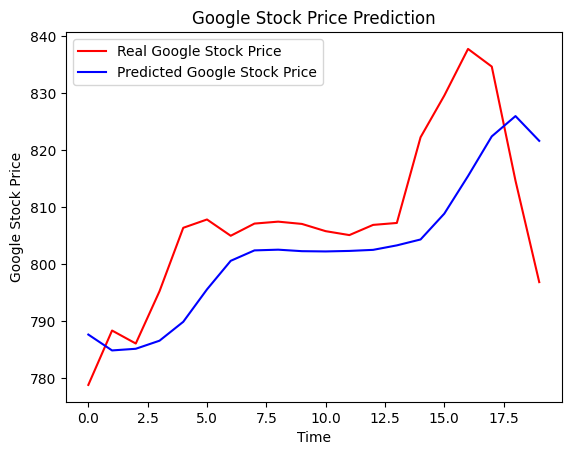

In [50]:
plt.plot(real_stock_price, color = 'red', label = 'Real Google Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()
